# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Capstone Project

Notebook 2: Data Cleaning & EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
# set the display to maximum for easy review of the data

pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
scripts = pd.read_csv('../data/seinfeld_scripts_no_title.csv')
scripts.head()

,character,line,episode
0,JERRY,"You know, why we're here? To be out, this is out...and out is one of the single most enjoyable experiences of life. People...did you ever hear people talking about ""We should go out""? This is what they're talking about...this whole thing, we're all out now, no one is home. Not one person here is home, we're all out! There are people tryin' to find us, they don't know where we are. (imitates one of these people ""tryin' to find us""; pretends his hand is a phone) ""Did you ring?, I can't find him."" (imitates other person on phone) ""Where did he go?"" (the first person again) ""He didn't tell me where he was going"". He must have gone out. You wanna go out: you get ready, you pick out the clothes, right? You take the shower, you get all ready, get the cash, get your friends, the car, the spot, the reservation...There you're staring around, whatta you do? You go: ""We gotta be getting back"". Once you're out, you wanna get back! You wanna go to sleep, you wanna get up, you wanna go out again tomorrow, right? Where ever you are in life, it's my feeling, you've gotta go. (Pete's luncheonette. Jerry and George are sitting at a table.)","GOOD NEWS, BAD NEWS"
1,JERRY,"Seems to me, that button is in the worst possible spot. (talking about George's shirt) The second button literally makes or breaks the shirt, look at it: it's too high! It's in no-man's-land, you look like you live with your mother.","GOOD NEWS, BAD NEWS"
2,GEORGE,Are you through? (kind of irritated),"GOOD NEWS, BAD NEWS"
3,JERRY,"You do of course try on, when you buy?","GOOD NEWS, BAD NEWS"
4,GEORGE,"Yes, it was purple, I liked it, I don't actually recall considering the buttons.","GOOD NEWS, BAD NEWS"


In [4]:
scripts.shape

(54211, 3)

Our data has 54,211 rows with 3 features.

### Data Cleaning

Thanks to the scraper built in the previous notebook, the scripts data is fairly clean. Each datapoint consists of three features: the character who was speaking, the corresponding line and the episode name. Upon inital examining, there were no null values or mismatched data types. 

In [5]:
# check null value just in case

scripts.isnull().sum()

character    0
line         0
episode      0
dtype: int64

In [6]:
# check data types

scripts.dtypes

character    object
line         object
episode      object
dtype: object

However, as I further investigated the data, some issues with the data surfaced: 1. there were typos of names in the character columns (i.e: Kramer spelled as "KRAMERT"); 2. inconsistancies in names for each character(i.e: "E", "ElAINE" both refer to as Elaine); 3. some cells in character columns were locations, or actions, not the characters (i.e: "JERRY MOCKING", "INT. MEETING ROOM - DAY"); 4. some lines were spoken by more than one character; 5. there are special characters that are non character names (i.e: "-----" or "======").

In order to reduce the complication of the model, following strategies were used to fix the above issues and clean the data:
1. remove datapoints that have less than  occurance because these data are not likely to provide any valuable inference for the model

In [7]:
occurrence = scripts.value_counts('character', ascending = True)
drop_rows = list(occurrence[occurrence<=10].index)

drop_index=[]
for row in drop_rows:
    ids = list(scripts[scripts['character'] == row].index)
    for i in ids:
        drop_index.append(i)
        
scripts.drop(drop_index, inplace=True)

scripts.reset_index(drop=True, inplace=True)

2. correct typos, redundant character names 

In [8]:
scripts['character'] = ['KRAMER' if i == 'KRAMER,' else i for i in scripts['character']]

In [9]:
scripts['character'] = ['JERRY' if i == 'JERRY,' else i for i in scripts['character']]

In [10]:
scripts['character'] = ['UNCLE LEO' if i == 'LEO' else i for i in scripts['character']]

In [11]:
scripts['character'] = ['JOE DAVOLA' if i == 'JOE DIVOLA' else i for i in scripts['character']]

In [12]:
scripts['character'] = ['WOMAN' if i == 'WOMEN' else i for i in scripts['character']]

3. correct misplaced lines due to the wrong formatting of the data source

In [13]:
for i in list(scripts[scripts.character == 'I'].index):
    scripts.iloc[i-1, 1] = scripts.iloc[i-1, 1] + ' ' + scripts.iloc[i, 0] + ' ' + scripts.iloc[i, 1]
    scripts.drop(i, inplace=True)

4. drop rows where dedicated to two speakers

In [14]:
scripts.drop(list(scripts[scripts['character'] == 'JERRY AND ELAINE'].index), inplace=True)

Moreover, there are 180 aired episodes for <em>Seinfeld</em>, however only 174 unique episodes were collected. This is because: 1. the data didn't include the four clip/highlight episodes - S6E14-E15 "The Highlights of 100", S9E21-E22 "The Clip Show"; 2. the website mislinked two of the regular episodes - S6E1 "The Chaperone" to "The Opposite", S6E7 "The Soup" to "The Soup Nazi", which results in the latter two episodes to have duplicate input in the data. I therefore decide to drop those duplicate rows.

In [15]:
len(scripts.episode.unique())

174

In [19]:
# drop dupliacte "the opposite" script

scripts[(scripts.episode == 'THE OPPOSITE')].loc[24104:24369]
scripts.drop(list(range(24104,24370)), inplace=True)
scripts.reset_index(drop=True, inplace=True)

In [24]:
# drop dupliacte "the soup nazi" script

scripts[scripts.episode == 'THE SOUP NAZI'].loc[25811:26197]
scripts.drop(list(range(25811,26198)), inplace=True)
scripts.reset_index(drop=True, inplace=True)

Our cleaned data now has 50,639 rows and 3 features.

In [25]:
scripts.shape

(50639, 3)

### Feature Engineering

In [26]:
# create word counts for each line 

def word_count(line):
    
    splited = line.split()
    final = []
    for chunk in splited:
        if '...' in chunk:
            chunk = chunk.split('...')
            for i in chunk:
                final.append(i)
        else:
            final.append(chunk)

    return len(final)


In [27]:
scripts['word_count'] = scripts['line'].map(word_count)

In [28]:
# concatenate the columns 

scripts['char_line'] = (scripts['character'] + ': ' + scripts['line'])

In [29]:
# convert to lowercase

scripts['char_line'] = scripts['char_line'].map(lambda x: x.lower())

### Exploratory Data Analysis

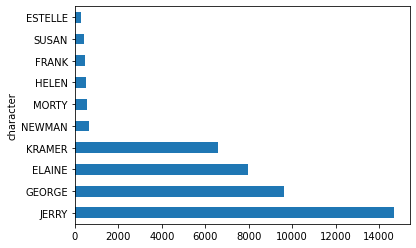

In [30]:
scripts.groupby('character')['line'].count().sort_values(ascending = False)[:10].plot.barh();

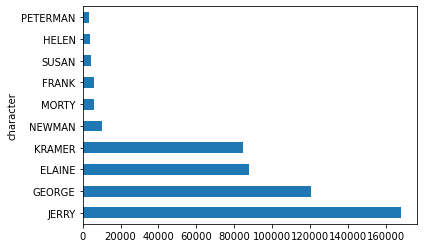

In [31]:
scripts.groupby('character')['word_count'].sum().sort_values(ascending = False)[:10].plot.barh();

In [32]:
def sentiment(text):
    sentiment = SentimentIntensityAnalyzer()
    score = sentiment.polarity_scores(text)
    return score['compound']

In [33]:
scripts['sentiment_score'] = scripts['line'].map(sentiment)

In [34]:
scripts.to_csv('../data/cleaned.csv', index=False)

In [35]:
def convert_sen(num):
    if num > 0:
        return 'positive'
    elif num == 0:
        return 'neutral'
    else:
        return 'negative'

In [36]:
scripts['sentiment'] = scripts['sentiment_score'].map(convert_sen)

In [37]:
char = ['JERRY', 'GEORGE', 'ELAINE', 'KRAMER', 'FRANK', 'MORTY', 'HELEN', 'SUSAN', 'ESTELLE', 'NEWMAN']

for name in char:
    scripts[scripts.character == name].groupby(['character', 'sentiment'])['sentiment_score'].count()

In [38]:
scripts[scripts.character == 'GEORGE'].groupby(['character', 'sentiment'])['sentiment_score'].count()

character  sentiment
GEORGE     negative     1797
           neutral      4513
           positive     3324
Name: sentiment_score, dtype: int64

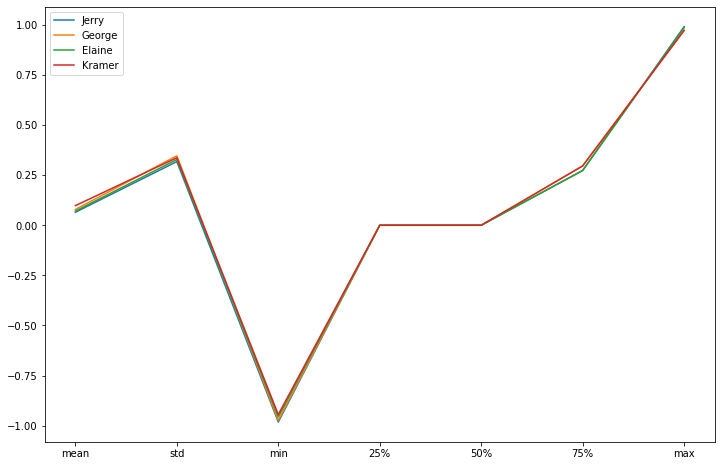

In [39]:
plt.figure(figsize = (12, 8))
plt.plot(scripts[scripts.character == 'JERRY']['sentiment_score'].describe()[1:], label='Jerry')
plt.plot(scripts[scripts.character == 'GEORGE']['sentiment_score'].describe()[1:], label='George')
plt.plot(scripts[scripts.character == 'ELAINE']['sentiment_score'].describe()[1:], label='Elaine')
plt.plot(scripts[scripts.character == 'KRAMER']['sentiment_score'].describe()[1:], label='Kramer')
plt.legend();

### How similar they are

### Most frequent used words by characters -- WordCloud

### Finalizing Data

In [40]:
df = pd.DataFrame(data=scripts['char_line'])
df.head()

,char_line
0,"jerry: you know, why we're here? to be out, this is out...and out is one of the single most enjoyable experiences of life. people...did you ever hear people talking about ""we should go out""? this is what they're talking about...this whole thing, we're all out now, no one is home. not one person here is home, we're all out! there are people tryin' to find us, they don't know where we are. (imitates one of these people ""tryin' to find us""; pretends his hand is a phone) ""did you ring?, i can't find him."" (imitates other person on phone) ""where did he go?"" (the first person again) ""he didn't tell me where he was going"". he must have gone out. you wanna go out: you get ready, you pick out the clothes, right? you take the shower, you get all ready, get the cash, get your friends, the car, the spot, the reservation...there you're staring around, whatta you do? you go: ""we gotta be getting back"". once you're out, you wanna get back! you wanna go to sleep, you wanna get up, you wanna go out again tomorrow, right? where ever you are in life, it's my feeling, you've gotta go. (pete's luncheonette. jerry and george are sitting at a table.)"
1,"jerry: seems to me, that button is in the worst possible spot. (talking about george's shirt) the second button literally makes or breaks the shirt, look at it: it's too high! it's in no-man's-land, you look like you live with your mother."
2,george: are you through? (kind of irritated)
3,"jerry: you do of course try on, when you buy?"
4,"george: yes, it was purple, i liked it, i don't actually recall considering the buttons."


In [41]:
texts='\n'.join(df['char_line'])

In [42]:
with open('../data/for_train.txt', 'w') as f:
    f.write(texts)